In [ ]:
import pynhd
import geopandas as gpd
import pandas as pd
import xarray as xr
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from chmdata.thredds import GridMet, BBox
import GRIDtools as gt

In [3]:
def delineate_watershed(coords):
    """
    Function that simplifies the work flow of pynhd split_catchment to delineate
    a basin upstream of a list of coordinates.
    """
    
    trace_attrs = ['req_idx', 'gnis_name', 'comid', 'reachcode', 'intersection_point']
    # add the required columns for pynhd trace_flow and split_catchment
    coords['direction'] = ['up'] * coords.shape[0]
    coords['upstream'] = [True] * coords.shape[0]
    # use flow trace service to find nearest stream feature
    trace = pynhd.pygeoapi(coords, "flow_trace")
    # add index as column for merging attribute fields and retain all but the geometry
    coords['req_idx'] = coords.index
    orig_attrs = coords.columns[coords.columns != 'geometry']
    # update point geometries to reflect hydro-adjusted points
    coords.geometry = [Point(x) for x in trace['intersection_point']]
    # delineate watersheds with adjusted points
    watersheds = pynhd.pygeoapi(coords, "split_catchment")

    # separate multi-part features and make valid
    watersheds = watersheds.explode()
    watersheds.geometry = watersheds.make_valid()
    watersheds = watersheds.explode()
    # remove the local catchment and keep only the full delineated area
    watersheds['Area_sqKm'] = watersheds.to_crs('5071').area / (1000**2)
    watersheds.sort_values(by='Area_sqKm', inplace=True)
    watersheds.drop_duplicates(subset='req_idx', keep='last', inplace=True)
    watersheds.reset_index(drop=True, inplace=True)

    # construct final GeoDataFrame with relevant attributes
    watersheds = watersheds.merge(coords[orig_attrs], on='req_idx')
    watersheds = watersheds.merge(trace[trace_attrs], on='req_idx')

    return watersheds
    

In [4]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
    },
    geometry=[Point(-114.133170, 46.748808),
              Point(-114.324042, 46.766956)],
    crs=4326
)

In [5]:
# Use delineate_watershed function to get polygon's of the contributing drainage area upstream of each point in GeoDataFrame
result = delineate_watershed(pour_pnt)

In [6]:
# view table
result

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-114.3272 46.7703, -114.327 46.77098...",28.323318,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32441916837779, 46.76677542470867]"
1,0,NaN,"POLYGON ((-114.14229 46.72534, -114.14578 46.7...",653.521298,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12978466856701, 46.7476919565746]"


<Axes: >

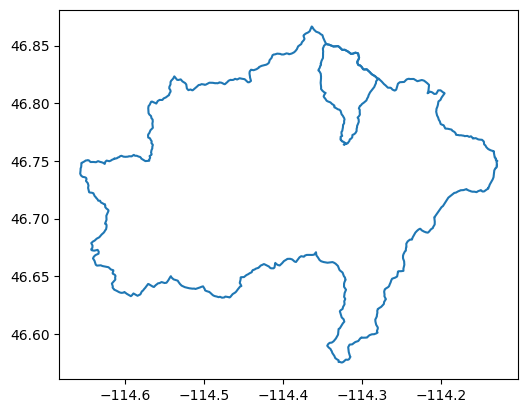

In [7]:
# plot watershed boundaries
result.boundary.plot()

In [8]:
# Use chmdata to get GridMET precipitation data for the area of interest
# Create the bbox
bnds = result.total_bounds
bbox = BBox(bnds[0]-0.5, bnds[2]+0.5, bnds[3]+0.5, bnds[1]-0.5)
gmet = GridMet(variable='pr', start='2016-01-01', end='2024-12-01', bbox=bbox)
prcp = gmet.subset_nc(return_array=True)

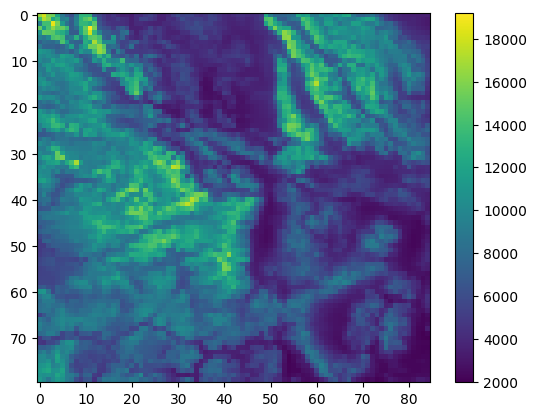

In [9]:
# view cumulative precip over the time period
plt.imshow(prcp.precipitation_amount.sum(dim='time'))
plt.colorbar()

In [10]:
dataset = prcp.precipitation_amount
# get grid resolution
xres, yres = dataset.rio.resolution()

# get the array bounds as variables for new geometry
gminx, gminy, gmaxx, gmaxy = dataset.rio.bounds()
# shape of dataset
nrows = dataset.shape[1]
ncols = dataset.shape[2]

nshp_cols = list(np.linspace(gminx, gmaxx, ncols+1))
nshp_rows = np.linspace(gminy, gmaxy, nrows+1)
nshp_rows = np.flip(nshp_rows)

grid_polygons = []
for y in nshp_rows[:-1]:
    for x in nshp_cols[:-1]:
        grid_polygons.append(Polygon([(x,y), (x+xres,y), (x+xres, y+yres), (x, y+yres)]))

In [11]:
grid_polys = gpd.GeoDataFrame(geometry=grid_polygons, crs=4326)

In [12]:
r_proj = result.to_crs(5071)
grd_proj = grid_polys.to_crs(5071)

In [25]:
# get in shape areas in Km^2
ingeom_areas = r_proj.area.values / (1000**2)

In [13]:
r_proj

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-1396543.179 2777343.302, -1396514.1...",28.323318,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32441916837779, 46.76677542470867]"
1,0,NaN,"POLYGON ((-1383570.819 2769750.75, -1383869.98...",653.521298,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12978466856701, 46.7476919565746]"


In [ ]:
geom_id_col = 'name'
in_geom = r_proj
intersection_geoms = []
in_shape_id = []
grid_cell_id = []
for i, g1 in enumerate(in_geom.geometry.values):
    for j, g2 in enumerate(grd_proj.geometry.values):
        if g1.intersects(g2):
            igeom = g1.intersection(g2)
            intersection_geoms.append(igeom)
            if geom_id_col is None:
                in_shape_id.append(i)
            elif geom_id_col in in_geom.columns.to_list():
                in_shape_id.append(in_geom[geom_id_col].iloc[i])
            else:
                raise ValueError("Argument for geom_id_col not found in input geometry columns.")
            grid_cell_id.append(j)

clipped_grid_shp = gpd.GeoDataFrame({
    "GridID": grid_cell_id,
    "FeatureID": in_shape_id
},
    geometry=intersection_geoms,
    crs=5071,
)
clipped_grid_shp['CellArea_sqm'] = clipped_grid_shp.geometry.area

In [ ]:
# Loop through unique feature ID's calculate the weighted volume for each
vol_series = []
for gid in in_geom[geom_id_col].to_list():
    qarea = pd.DataFrame(clipped_grid_shp.loc[clipped_grid_shp['FeatureID'] == gid]['CellArea_sqKm'],
                            index=clipped_grid_shp.loc[clipped_grid_shp['FeatureID'] == gid].index)
    allcells = pd.concat([qarea, grid_polys], axis=1)
    area_arry = allcells['CellArea_sqKm'].values.reshape(nrows, ncols)
    md_arry = dataset.values
    vol_grd = area_arry * (md_arry / 1000)
    vol_v = np.nansum(vol_grd, axis=(1, 2))
    vol_v = vol_v.reshape(vol_v.size, 1)
    vol_series.append(vol_v)

In [36]:
# Create xarray dataset of result
agg_dset = xr.Dataset(
    {
        "precip_volume": (['time', 'location'], np.hstack(vol_series), {'standard_name': 'Area Weighted Precipitation Volume',
                                                                        'units': 'm^3'}),                                        
    },
    coords={
        "location": (['location'], in_geom[geom_id_col].to_list(), {'long_name': 'location_identifier',
                                                                    'cf_role': 'timeseries_id'}),
        "area": (['location'], ingeom_areas, {'standard_name': 'area',
                                              'long_name': 'input_shape_area',
                                              'units': 'km^2'}),
        "time": dataset.indexes['time']
    },
    attrs={
        "featureType": 'timeSeries'
    }
)

In [47]:
agg_dset

<xarray.Dataset> Size: 78kB
Dimensions:        (time: 3258, location: 2)
Coordinates:
  * location       (location) <U20 160B 'Bear_Creek_Catchment' 'Lolo_Catchment'
    area           (location) float64 16B 28.32 653.5
  * time           (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
Data variables:
    precip_volume  (time, location) float64 52kB 0.0 2.825e+07 0.0 ... 0.0 0.0
Attributes:
    featureType:  timeSeries

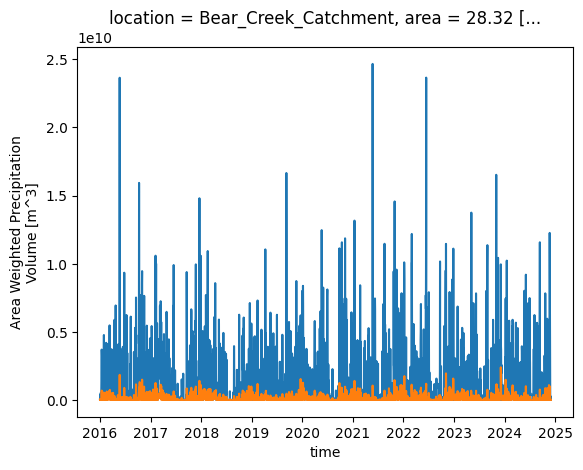

In [44]:
ax = plt.axes()
agg_dset.precip_volume.sel(location='Lolo_Catchment').plot()
agg_dset.precip_volume.sel(location='Bear_Creek_Catchment').plot()


In [46]:
agg_dset.sum(dim='time')

<xarray.Dataset> Size: 192B
Dimensions:        (location: 2)
Coordinates:
  * location       (location) <U20 160B 'Bear_Creek_Catchment' 'Lolo_Catchment'
    area           (location) float64 16B 28.32 653.5
Data variables:
    precip_volume  (location) float64 16B 4.074e+11 4.06e+12

In [50]:
r_proj = result.to_crs(5071)
grd_proj = grd_shp.to_crs(5071)

In [57]:
sj1 = r_proj.sjoin(grd_proj, how='left')
sj2 = grd_proj.sjoin(r_proj, how='right')

In [71]:
sj2['req_idx'].iloc[1]

np.int64(1)

In [46]:
sj2.intersection(sj1, align=True)

0       None
1       None
2       None
3       None
4       None
        ... 
6795    None
6796    None
6797    None
6798    None
6799    None
Length: 6821, dtype: geometry

<Axes: >

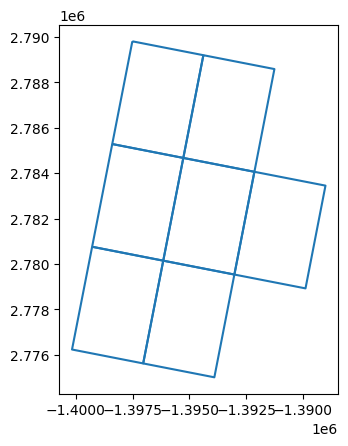

In [11]:
pour_pnt['direction'] = ['up'] * pour_pnt.shape[0]
pour_pnt['upstream'] = [True] * pour_pnt.shape[0]

In [12]:
pour_pnt

,name,geometry,direction,upstream
0,Lolo_Catchment,POINT (-114.13317 46.74881),up,True
1,Bear_Creek_Catchment,POINT (-114.32404 46.76696),up,True


In [13]:
trace = pynhd.pygeoapi(pour_pnt, "flow_trace")

In [14]:
trace


,req_idx,geometry,gnis_name,comid,intersection_point,reachcode,raindrop_pathDist,measure,raindrop_path
0,0,"LINESTRING (-114.13527 46.74652, -114.13467 46...",Lolo Creek,24319270,"[-114.12978466856701, 46.7476919565746]",17010205000088,351.63,74.91,"LINESTRING (-114.1333 46.74888, -114.13292 46...."
1,1,"LINESTRING (-114.31475 46.80174, -114.31465 46...",Bear Creek,24321310,"[-114.32441916837779, 46.76677542470867]",17010205001011,NaN,10.96,None


In [20]:
new_pour_pnts = pour_pnt
new_pour_pnts.geometry = [Point(x) for x in trace['intersection_point']]
new_pour_pnts['req_idx'] = new_pour_pnts.index
new_pour_pnts

,name,geometry,direction,upstream,req_idx
0,Lolo_Catchment,POINT (-114.12978 46.74769),up,True,0
1,Bear_Creek_Catchment,POINT (-114.32442 46.76678),up,True,1


In [41]:
new_pour_pnts[new_pour_pnts.columns[new_pour_pnts.columns != 'geometry']]

,name,direction,upstream,req_idx
0,Lolo_Catchment,up,True,0
1,Bear_Creek_Catchment,up,True,1


In [22]:
new_pour_pnts.merge(trace[['req_idx', 'gnis_name', 'comid', 'reachcode']], on='req_idx')

,name,geometry,direction,upstream,req_idx,gnis_name,comid,reachcode
0,Lolo_Catchment,POINT (-114.12978 46.74769),up,True,0,Lolo Creek,24319270,17010205000088
1,Bear_Creek_Catchment,POINT (-114.32442 46.76678),up,True,1,Bear Creek,24321310,17010205001011


In [50]:
cats = pynhd.pygeoapi(new_pour_pnts, "split_catchment")

In [53]:
cats.explode()

,req_idx,catchmentID,geometry
0,0,24319270,"POLYGON ((-114.14072 46.72623, -114.14065 46.7..."
0,0,24319270,"POLYGON ((-114.14072 46.72623, -114.13939 46.7..."
1,0,NaN,"POLYGON ((-114.14065 46.72596, -114.14104 46.7..."
1,0,NaN,"POLYGON ((-114.11652 46.75512, -114.11643 46.7..."
1,0,NaN,"POLYGON ((-114.11538 46.75389, -114.11506 46.7..."
1,0,NaN,"POLYGON ((-114.13341 46.72822, -114.13429 46.7..."
2,1,24321310,"POLYGON ((-114.32851 46.7636, -114.32915 46.76..."
3,1,NaN,"POLYGON ((-114.32894 46.76426, -114.32823 46.7..."
3,1,NaN,"POLYGON ((-114.3272 46.7703, -114.327 46.77098..."


In [54]:
cats = cats.explode()
cats['Area_sqKm'] = cats.to_crs('5071').area / (1000**2)
cats.sort_values(by='Area_sqKm', inplace=True)
cats.drop_duplicates(subset='req_idx', keep='last', inplace=True)
cats.reset_index(drop=True, inplace=True)
cats

,req_idx,catchmentID,geometry,Area_sqKm
0,1,NaN,"POLYGON ((-114.3272 46.7703, -114.327 46.77098...",28.323318
1,0,NaN,"POLYGON ((-114.14065 46.72596, -114.14104 46.7...",653.521298


In [68]:
(cats.geom_type == 'Polygon').all()

np.False_

In [35]:
nldi = pynhd.NLDI()

In [50]:
basin_nosplit = nldi.get_basins(trace['comid'].to_list(), fsource='comid')
#basin_split = nldi.get_basins([trace['comid'].loc[1]], fsource='comid', split_catchment=True)

<Axes: >

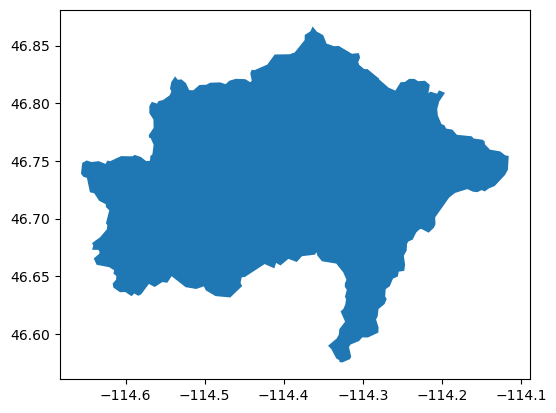

In [56]:
ax = plt.axes()
basin_nosplit.plot(ax=ax)
#basin_split.boundary.plot(ax=ax)


In [23]:
cats = pynhd.pygeoapi(pour_pnt, "split_catchment")

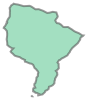

In [30]:
cats.loc[3].geometry